In [2]:
%reload_ext autoreload
%autoreload 2

import os
os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import data.s3 as s3u
import evaluation.eval_framework as evu

import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from io import BytesIO
from plotnine import *

In [3]:
kwargs = {
    "max_percent_capacity": 0.95,  # highest level of charge achieved by battery
    "user_charge_tolerance": 0.8,  # user preferred min charge
    "power_output_efficiency": 0.75,  # power loss. 1 = no power loss.
    "average_battery_starting_capacity": 0.5,  # average starting percent charged
    "start_hour": "00:00:00",  # earliest session can start
    "end_hour": "17:00:00",  # latest session can start
}

In [4]:
test_time = pd.to_datetime("2023-04-01 12:00:00")
regions = [
    "CAISO_NORTH",
    "SPP_TX",
    "ERCOT_EASTTX",
    "FPL",
    "SOCO",
    "PJM_CHICAGO",
    "PJM_DC",
    "LDWP",
    "NYISO_NYC",
]

In [5]:
import random
from datetime import datetime, timedelta

def random_dates(start, end, n):
    dates = []
    time_between_dates = end - start
    for _ in range(n):
        random_number_of_days = random.randrange(time_between_dates.days)
        random_date = start + timedelta(days=random_number_of_days)
        random_hour = random.randrange(24)  # Random hour in a day
        random_datetime = random_date.replace(hour=random_hour)
        dates.append(random_datetime)
    return dates

In [6]:
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 1, 1)

rand_dates = random_dates(start_date, end_date, 500)
dates_df = pd.DataFrame({"date_time" : rand_dates})

In [7]:
def get_fcst(time, region, hours):
    try:
        return evu.get_historical_fcst_data(time, hours*12, region=region)["value"].tolist()[:144]
    except Exception as e:
        return np.nan
    
def get_history(time, region, hours):
    try:
        return evu.get_historical_actual_data(time, hours*12, region=region)["value"].tolist()[:144]
    except Exception as e:
        return np.nan

In [70]:
for region in regions:
    print(region)
    
    dates_df[f"fcst_{region}"] = dates_df.apply(
        lambda x: get_fcst(x.date_time, region, 12),
        axis=1,
    )

    dates_df[f"actual_{region}"] = dates_df.apply(
        lambda x: get_history(x.date_time, region, 12),
        axis=1,
    )

    dates_df[f"difference_{region}"] = dates_df.apply(
        lambda x: np.subtract(x[f"actual_{region}"], x[f"fcst_{region}"]),
        axis=1
    )

    dates_df[f"MSE_{region}"] = dates_df.apply(
        lambda x: np.mean(x[f"difference_{region}"]**2),
        axis=1
    )

dates_df.to_parquet("actuals_forecast2.parquet")

CAISO_NORTH
SPP_TX
ERCOT_EASTTX
FPL

 Warnings Returned: {'region': 'FPL', 'signal_type': 'co2_moer', 'horizon_hours': 12, 'start': Timestamp('2023-06-02 03:55:00+0000', tz='UTC'), 'end': Timestamp('2023-06-02 04:00:00+0000', tz='UTC')} {'data_point_period_seconds': 300, 'region': 'FPL', 'signal_type': 'co2_moer', 'units': 'lbs_co2_per_mwh', 'warnings': [{'type': 'MISSING_DATA', 'message': 'You made a valid request, but we have some datapoints missing. This can happen for a variety of reasons. If the data is less than a week old, we will most likely fill in this data soon. If it is older than that, we are missing enough important grid data during this time period that we are not able to generate an accurate estimate'}], 'model': {'date': '2022-10-01'}, 'generated_at_period_seconds': 300}

 Warnings Returned: {'region': 'FPL', 'signal_type': 'co2_moer', 'horizon_hours': 12, 'start': Timestamp('2023-06-02 03:55:00+0000', tz='UTC'), 'end': Timestamp('2023-06-02 04:00:00+0000', tz='UTC')} 

In [8]:
forecasts_history = pd.read_parquet("actuals_forecast2.parquet")

In [12]:
MSE_columns = forecasts_history.columns.str.contains("MSE")

In [13]:
(forecasts_history["difference_CAISO_NORTH"][1]).min()

np.float64(-891.4)

/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 8 rows containing non-finite values.


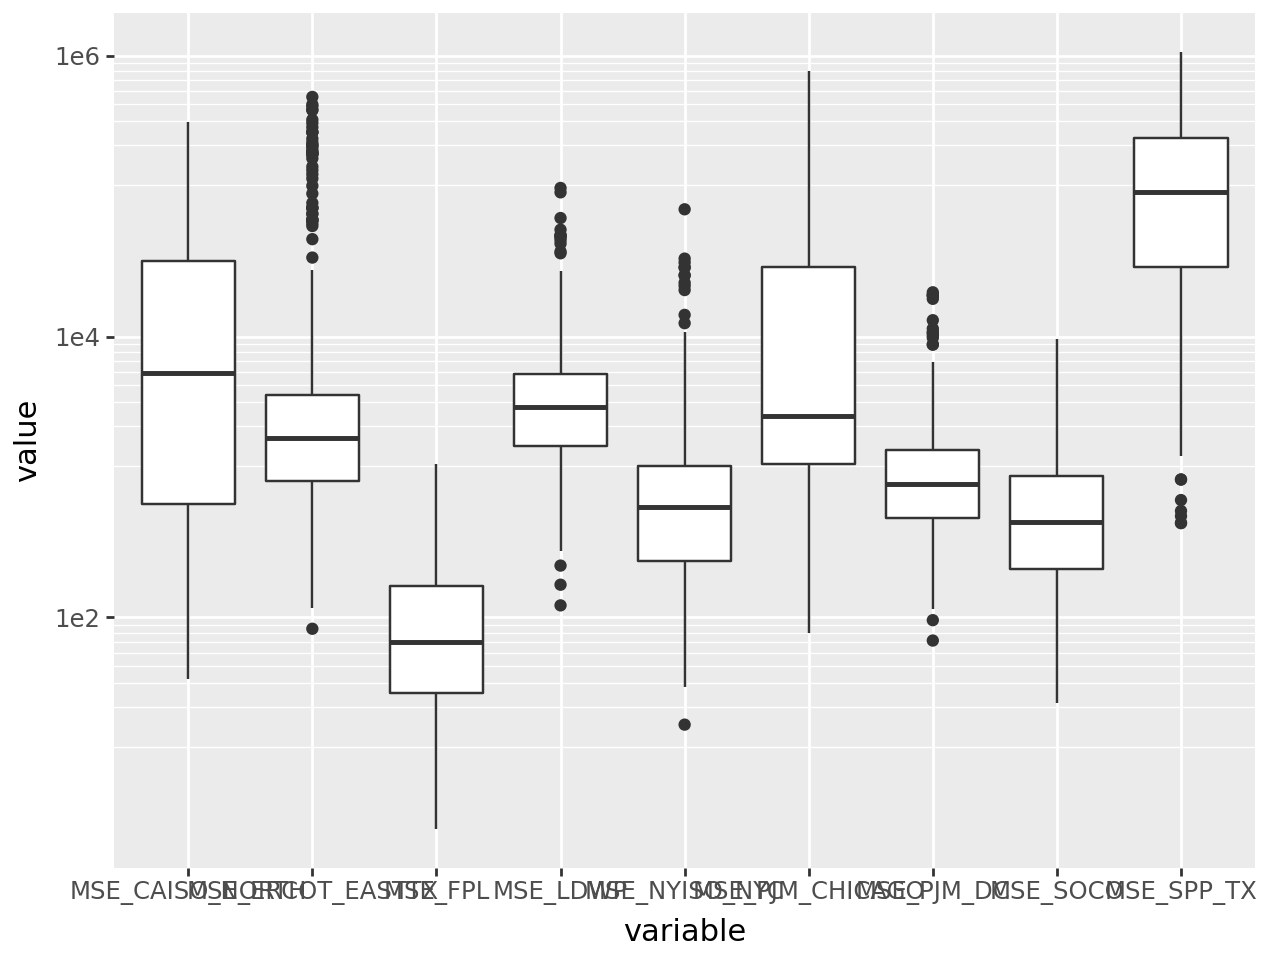

In [14]:
plot_dat = forecasts_history.loc[:, MSE_columns].melt()
#plot_dat["value"] = np.log10(plot_dat["value"])
(ggplot(plot_dat, aes(x = "variable", y = "value")) + geom_boxplot() + scale_y_log10())

In [11]:
def get_hourly_MADs(diff_vec, hours = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]):
    out = {}
    for hour in hours:
        out[hour] = float(np.median(abs(diff_vec[(hour - 1) * 12 : hour * 12])))

    return out

def get_hourly_MAPEs(diff_vec, actual_vec, hours = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]):
    out = {}
    for hour in hours:
        hour_diffs = diff_vec[(hour - 1) * 12 : hour * 12]
        hour_actuals = actual_vec[(hour - 1) * 12 : hour * 12]

        pct_errors = np.abs(hour_diffs / hour_actuals)
        out[hour] = float(np.mean(pct_errors))

    return out

In [12]:
for region in regions:
    forecasts_history[f"hourly_MAD_{region}"] = forecasts_history.apply(
        lambda x: get_hourly_MADs(x[f"difference_{region}"]),
        axis=1
    )

    forecasts_history[f"hourly_MAPE_{region}"] = forecasts_history.apply(
        lambda x: get_hourly_MAPEs(x[f"difference_{region}"], actual_vec=x[f"actual_{region}"]),
        axis=1
    )

/tmp/ipykernel_1955414/3605364779.py:14: RuntimeWarning: divide by zero encountered in divide
/tmp/ipykernel_1955414/3605364779.py:14: RuntimeWarning: divide by zero encountered in divide


In [25]:
TX = forecasts_history[["date_time", "actual_SPP_TX", "fcst_SPP_TX", "difference_SPP_TX", "hourly_MAD_SPP_TX"]]
TX["fcst_var"] = TX.apply(lambda x: np.var(x.fcst_SPP_TX), axis = 1)
TX["actual_var"] = TX.apply(lambda x: np.var(x.actual_SPP_TX), axis = 1)
TX

/tmp/ipykernel_1955414/2353908290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1955414/2353908290.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date_time,actual_SPP_TX,fcst_SPP_TX,difference_SPP_TX,hourly_MAD_SPP_TX,fcst_var,actual_var
0,2023-10-15 13:00:00,"[1466.0, 1467.0, 1471.0, 1470.0, 1468.0, 1466....","[1415.2, 1415.2, 1399.0, 1397.7, 1391.5, 1390....","[50.799999999999955, 51.799999999999955, 72.0,...","{1: 79.89999999999998, 2: 115.95000000000005, ...",6847.801793,10357.558594
1,2023-01-26 11:00:00,"[1351.0, 1371.0, 1393.0, 1375.0, 1374.0, 1366....","[1350.2, 1350.2, 1347.4, 1344.3, 1345.0, 1345....","[0.7999999999999545, 20.799999999999955, 45.59...","{1: 10.050000000000068, 2: 17.700000000000045,...",115423.592496,330268.543933
2,2023-05-07 14:00:00,"[1413.0, 421.0, 424.0, 425.0, 422.0, 422.0, 42...","[1390.7, 1390.7, 1380.3, 1373.2, 1368.1, 1360....","[22.299999999999955, -969.7, -956.3, -948.2, -...","{1: 936.85, 2: 1200.0, 3: 1106.25, 4: 1116.4, ...",121736.537878,352187.627267
3,2023-03-26 11:00:00,"[1454.0, 1453.0, 1454.0, 1455.0, 1455.0, 1452....","[1430.0, 1430.0, 1422.6, 1416.2, 1413.1, 1410....","[24.0, 23.0, 31.40000000000009, 38.79999999999...","{1: 50.65000000000009, 2: 80.04999999999995, 3...",9725.258331,199170.694252
4,2023-02-17 10:00:00,"[1342.0, 1348.0, 1354.0, 1357.0, 1348.0, 1348....","[1337.3, 1337.3, 1334.8, 1332.1, 1330.5, 1326....","[4.7000000000000455, 10.700000000000045, 19.20...","{1: 14.700000000000045, 2: 28.450000000000045,...",29910.338680,225700.629437
...,...,...,...,...,...,...,...
495,2023-12-09 07:00:00,"[1411.0, 1410.0, 1405.0, 1405.0, 1416.0, 1422....","[1346.4, 1346.4, 1322.4, 1314.5, 1292.4, 1292....","[64.59999999999991, 63.59999999999991, 82.5999...","{1: 134.25, 2: 463.0, 3: 1015.25, 4: 403.1, 5:...",99192.049340,445899.615693
496,2023-03-03 02:00:00,"[1447.0, 1447.0, 1433.0, 1432.0, 1432.0, 1432....","[1413.1, 1413.1, 1397.8, 1392.3, 1387.3, 1379....","[33.90000000000009, 33.90000000000009, 35.2000...","{1: 57.85000000000002, 2: 176.60000000000002, ...",9291.741788,277923.054784
497,2023-11-03 08:00:00,"[24.0, 25.0, 25.0, 22.0, 40.0, 59.0, 64.0, 35....","[91.5, 91.5, 111.4, 125.6, 132.3, 139.9, 151.7...","[-67.5, -66.5, -86.4, -103.6, -92.300000000000...","{1: 90.0, 2: 981.3, 3: 145.60000000000002, 4: ...",135494.879305,164591.423611
498,2023-06-07 11:00:00,"[1371.0, 1358.0, 1355.0, 1352.0, 1353.0, 1354....","[1355.8, 1355.8, 1352.0, 1353.7, 1351.5, 1348....","[15.200000000000045, 2.2000000000000455, 3.0, ...","{1: 11.400000000000091, 2: 43.299999999999955,...",799.192353,274.706597


In [27]:
TX.loc[4].hourly_MAD_SPP_TX

{1: 14.700000000000045,
 2: 28.450000000000045,
 3: 161.54999999999995,
 4: 175.5999999999999,
 5: 185.79999999999995,
 6: 216.95000000000005,
 7: 210.45000000000005,
 8: 156.75,
 9: 187.30000000000007,
 10: 351.6,
 11: 1032.55,
 12: 465.4}

In [15]:
forecasts_history

,date_time,fcst_CAISO_NORTH,actual_CAISO_NORTH,difference_CAISO_NORTH,MSE_CAISO_NORTH,fcst_SPP_TX,actual_SPP_TX,difference_SPP_TX,MSE_SPP_TX,fcst_ERCOT_EASTTX,...,hourly_MAD_SOCO,hourly_MAPE_SOCO,hourly_MAD_PJM_CHICAGO,hourly_MAPE_PJM_CHICAGO,hourly_MAD_PJM_DC,hourly_MAPE_PJM_DC,hourly_MAD_LDWP,hourly_MAPE_LDWP,hourly_MAD_NYISO_NYC,hourly_MAPE_NYISO_NYC
0,2023-10-15 13:00:00,"[127.9, 127.9, 141.1, 147.9, 151.5, 166.4, 163...","[101.0, 103.0, 158.0, 157.0, 257.0, 257.0, 257...","[-26.900000000000006, -24.900000000000006, 16....",20577.225486,"[1415.2, 1415.2, 1399.0, 1397.7, 1391.5, 1390....","[1466.0, 1467.0, 1471.0, 1470.0, 1468.0, 1466....","[50.799999999999955, 51.799999999999955, 72.0,...",56849.079931,"[1150.0, 1150.0, 1146.0, 1159.5, 1170.2, 1161....",...,"{1: 19.0, 2: 24.40000000000009, 3: 21.40000000...","{1: 0.016501924679540734, 2: 0.020384053908507...","{1: 38.0, 2: 31.300000000000068, 3: 69.8000000...","{1: 0.03300937017327351, 2: 0.0299761437420479...","{1: 61.69999999999993, 2: 39.10000000000002, 3...","{1: 0.0407011595270862, 2: 0.03259332388514020...","{1: 14.900000000000091, 2: 22.149999999999977,...","{1: 0.013037124413098925, 2: 0.019215012279053...","{1: 2.650000000000034, 2: 23.700000000000045, ...","{1: 0.005422271819306855, 2: 0.024172538318667..."
1,2023-01-26 11:00:00,"[1010.5, 1010.5, 1014.2, 1014.1, 1015.1, 1020....","[1009.0, 1019.0, 1040.0, 1045.0, 1046.0, 1045....","[-1.5, 8.5, 25.799999999999955, 30.89999999999...",65174.569028,"[1350.2, 1350.2, 1347.4, 1344.3, 1345.0, 1345....","[1351.0, 1371.0, 1393.0, 1375.0, 1374.0, 1366....","[0.7999999999999545, 20.799999999999955, 45.59...",100370.423403,"[1205.9, 1205.9, 1205.1, 1204.9, 1204.7, 1204....",...,"{1: 28.09999999999991, 2: 6.099999999999909, 3...","{1: 0.02984058130371831, 2: 0.0066103365675590...","{1: 27.25, 2: 22.25, 3: 12.199999999999932, 4:...","{1: 0.01926801582730064, 2: 0.0166825338511323...","{1: 2.699999999999932, 2: 15.0, 3: 10.75, 4: 6...","{1: 0.0022750395867805607, 2: 0.01110094619759...","{1: 35.84999999999991, 2: 40.75, 3: 34.1000000...","{1: 0.02717483506128225, 2: 0.0315499439400525...","{1: 1.5500000000000114, 2: 18.75, 3: 9.5, 4: 1...","{1: 0.004457079706146484, 2: 0.018985461011998..."
2,2023-05-07 14:00:00,"[77.7, 77.7, 86.2, 112.8, 109.5, 120.5, 128.7,...","[90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 92.0, 92....","[12.299999999999997, 12.299999999999997, 3.799...",30786.066042,"[1390.7, 1390.7, 1380.3, 1373.2, 1368.1, 1360....","[1413.0, 421.0, 424.0, 425.0, 422.0, 422.0, 42...","[22.299999999999955, -969.7, -956.3, -948.2, -...",709008.267847,"[1201.7, 1201.7, 1199.4, 1197.4, 1196.0, 1194....",...,"{1: 3.0, 2: 27.59999999999991, 3: 28.700000000...","{1: 0.0038915347286350107, 2: 0.02164193613086...","{1: 31.700000000000045, 2: 36.64999999999998, ...","{1: 0.0263323660361784, 2: 0.03239989980319733...","{1: 39.05000000000007, 2: 34.799999999999955, ...","{1: 0.03313193878261971, 2: 0.0307652501141935...","{1: 19.700000000000045, 2: 12.850000000000023,...","{1: 0.018482071548367836, 2: 0.011621247370151...","{1: 9.949999999999989, 2: 7.349999999999966, 3...","{1: 0.009894687980701925, 2: 0.024415817715019..."
3,2023-03-26 11:00:00,"[113.0, 113.0, 118.2, 138.8, 138.0, 138.3, 130...","[94.0, 94.0, 94.0, 93.0, 94.0, 94.0, 92.0, 92....","[-19.0, -19.0, -24.200000000000003, -45.800000...",33756.655972,"[1430.0, 1430.0, 1422.6, 1416.2, 1413.1, 1410....","[1454.0, 1453.0, 1454.0, 1455.0, 1455.0, 1452....","[24.0, 23.0, 31.40000000000009, 38.79999999999...",143398.291528,"[1185.4, 1185.4, 1180.4, 1194.1, 1193.6, 1193....",...,"{1: 22.299999999999955, 2: 1.400000000000091, ...","{1: 0.019620104931590956, 2: 0.003988288310201...","{1: 10.149999999999977, 2: 30.899999999999977,...","{1: 0.008771057485082412, 2: 0.026179858006585...","{1: 40.450000000000045, 2: 10.699999999999932,...","{1: 0.029426259574217458, 2: 0.012153265953154...","{1: 11.850000000000023, 2: 79.89999999999998, ...","{1: 0.014039251480880135, 2: 0.063605267193067...","

In [41]:
MAD_cols = forecasts_history.columns.str.contains("MAD")
MAPE_cols = forecasts_history.columns.str.contains("MAPE")

In [46]:
plot_dat = forecasts_history.iloc[:, MAD_cols].melt()
exploded_df = pd.json_normalize(plot_dat['value'])
plot_dat = plot_dat.drop(columns=['value']).join(exploded_df)

In [47]:
def compute_boxplot_stats(df, group_col, value_col):
    """
    Compute the five-number summary for a given DataFrame grouped by a column.

    Parameters:
    - df: DataFrame containing the data
    - group_col: Column to group by (e.g., 'hour')
    - value_col: Column containing the values to compute the stats (e.g., 'value')

    Returns:
    - A DataFrame with the columns 'group_col', 'min', 'q25', 'median', 'q75', and 'max'.
    """
    return (df.groupby(group_col)[value_col]
              .agg(min=lambda x: x.quantile(0.10),
                   q25=lambda x: x.quantile(0.25),
                   median='median',
                   q75=lambda x: x.quantile(0.75),
                   max=lambda x: x.quantile(0.90))
              .reset_index())

In [48]:
plot_dat = plot_dat.melt(id_vars=["variable"], var_name="hour")

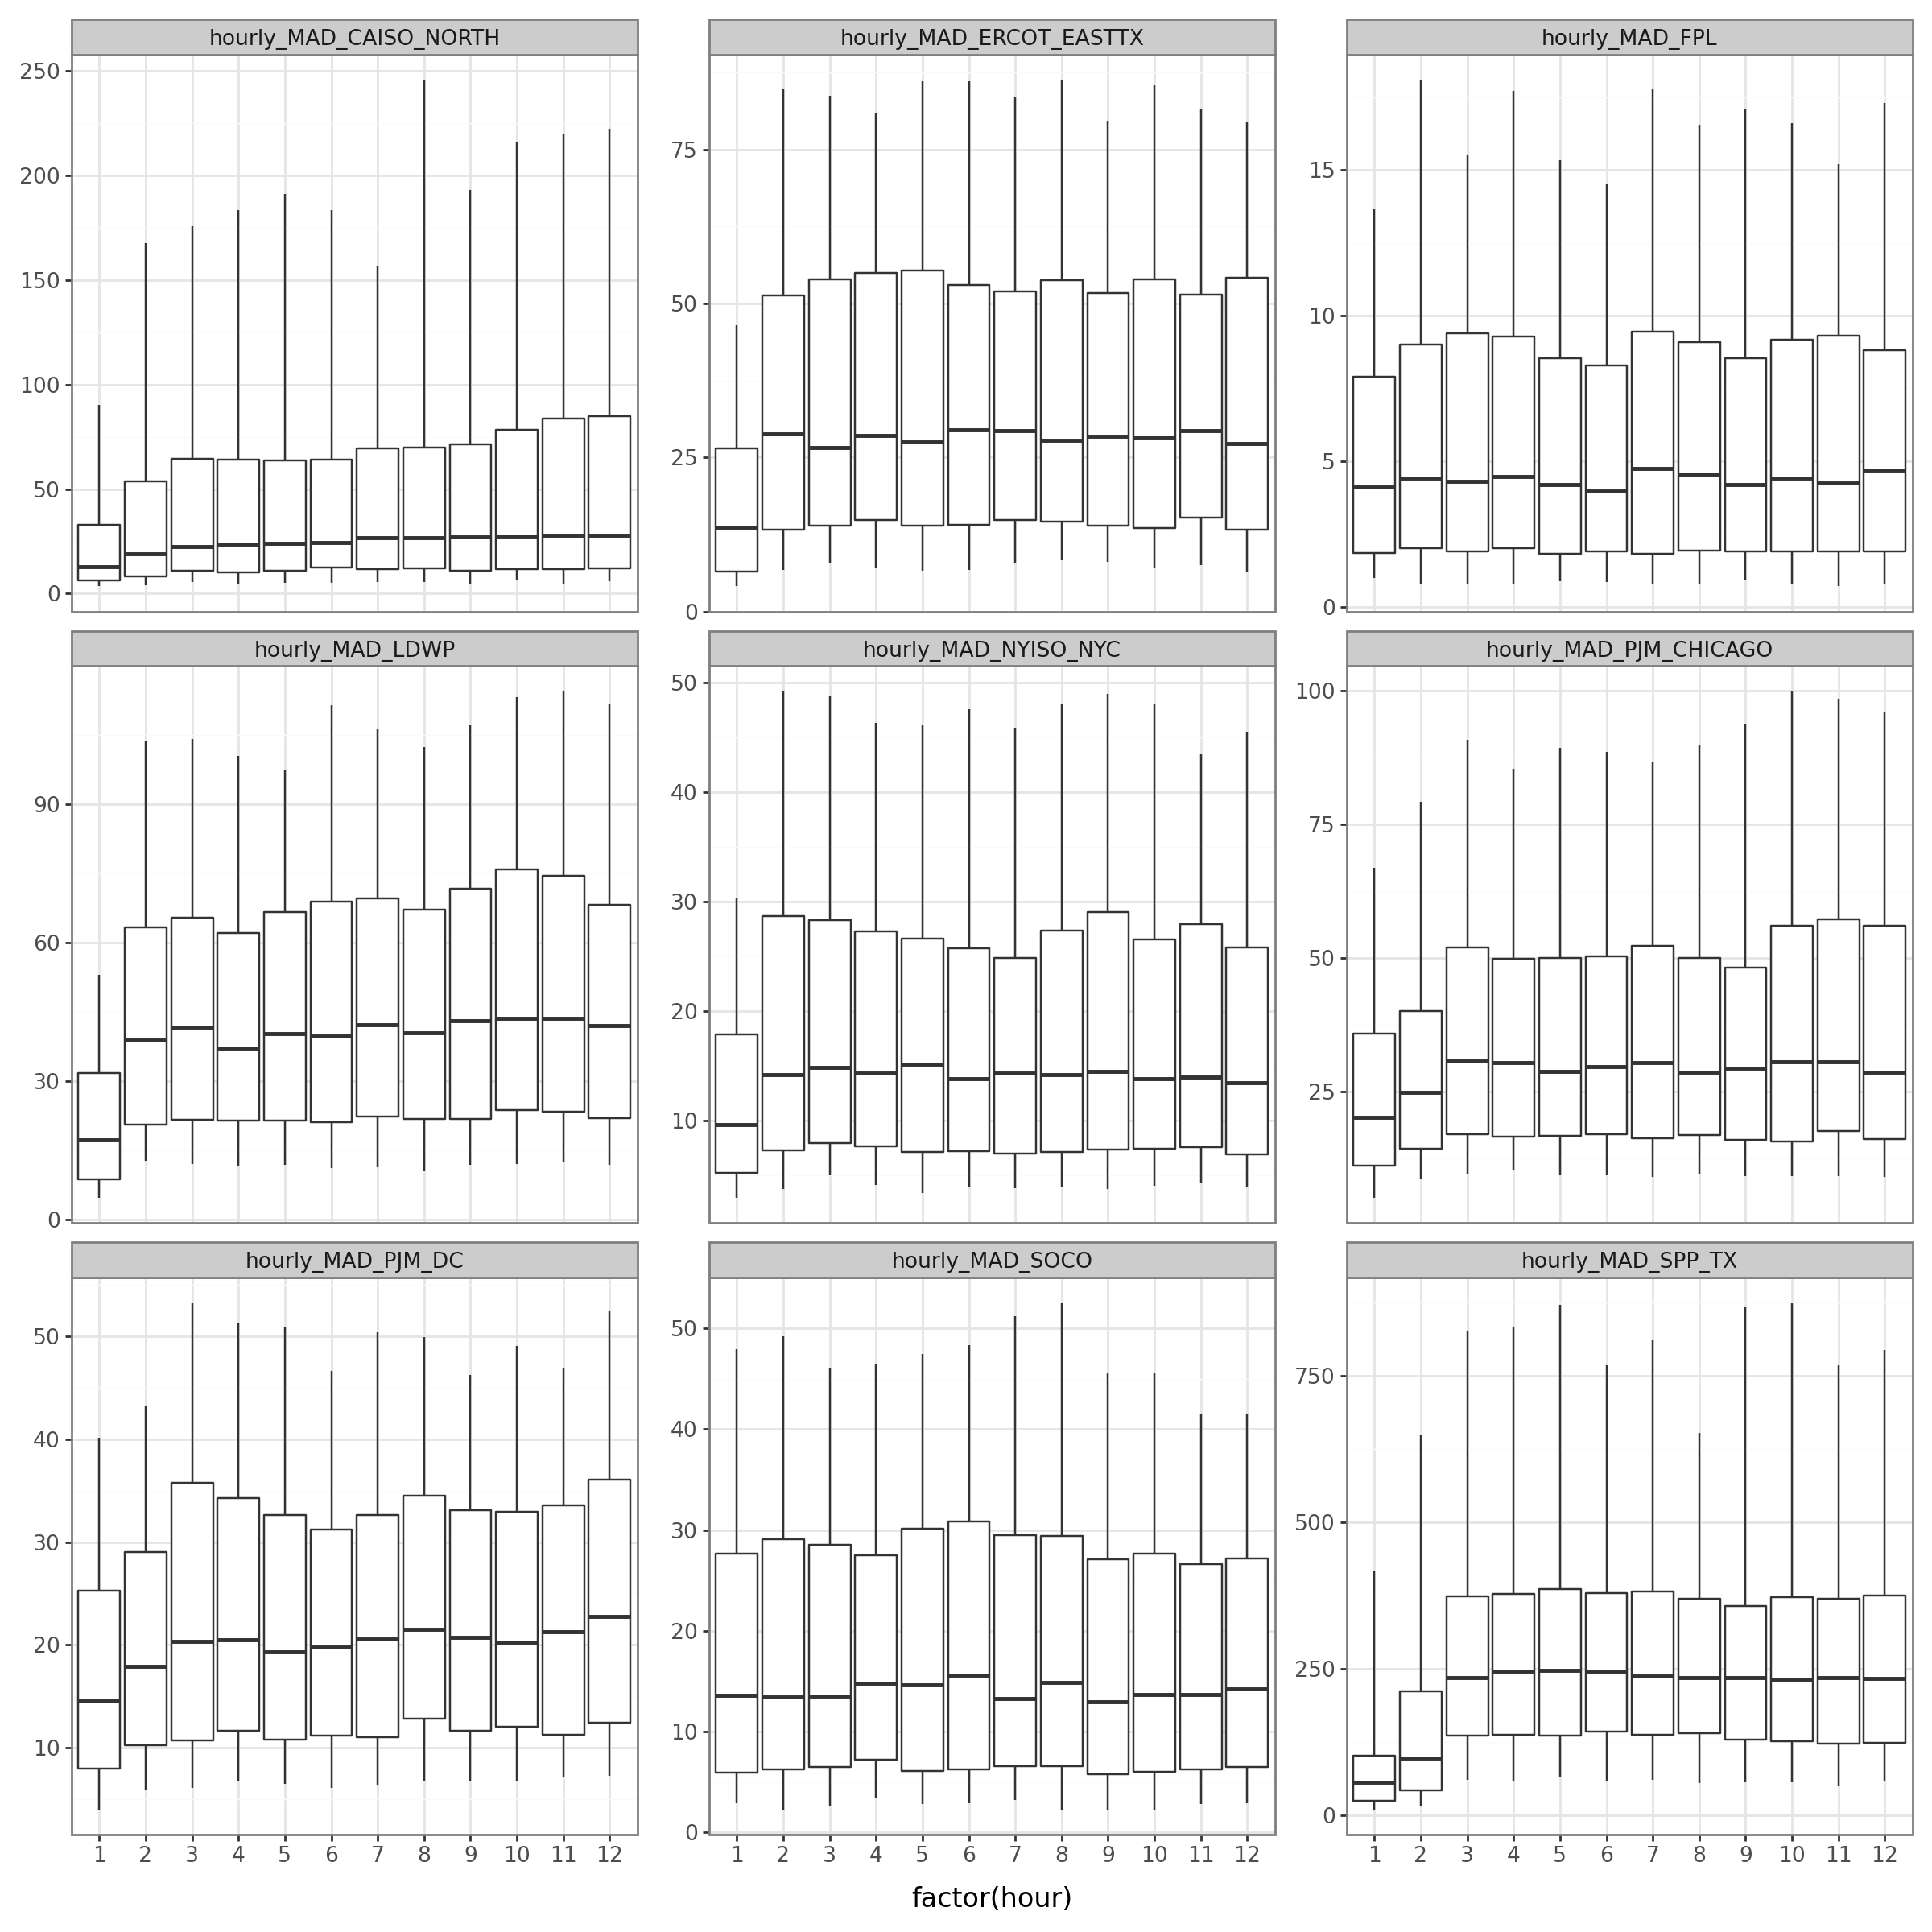

In [49]:
(ggplot(compute_boxplot_stats(plot_dat, ["variable", "hour"], "value"), aes(x = "factor(hour)")) +  geom_boxplot(
        aes(
            ymin='min',
            lower='q25',
            middle='median',
            upper='q75',
            ymax='max'
        ), 
        stat='identity'
    ) + facet_wrap("~variable", scales = "free_y") + theme_bw(base_size = 12) + theme(figure_size=(12,12)))

In [115]:
plot_dat.groupby(["variable", "hour"])["value"].median().reset_index()

,variable,hour,value
0,hourly_MAPE_CAISO_NORTH,1,12.850
1,hourly_MAPE_CAISO_NORTH,2,15.075
2,hourly_MAPE_CAISO_NORTH,4,19.200
3,hourly_MAPE_CAISO_NORTH,6,20.275
4,hourly_MAPE_CAISO_NORTH,8,21.625
5,hourly_MAPE_CAISO_NORTH,12,24.800
6,hourly_MAPE_ERCOT_EASTTX,1,13.725
7,hourly_MAPE_ERCOT_EASTTX,2,20.650
8,hourly_MAPE_ERCOT_EASTTX,4,23.550
9,hourly_MAPE_ERCOT_EASTTX,6,25.875


In [81]:
plot_dat["value"]

0       {1: np.float64(92.14999999999999), 2: np.float...
1       {1: np.float64(19.149999999999977), 2: np.floa...
2       {1: np.float64(33.599999999999994), 2: np.floa...
3       {1: np.float64(41.3), 2: np.float64(49.4499999...
4       {1: np.float64(37.349999999999966), 2: np.floa...
                              ...                        
4495    {1: np.float64(5.349999999999966), 2: np.float...
4496    {1: np.float64(3.349999999999966), 2: np.float...
4497    {1: np.float64(8.75), 2: np.float64(11.75), 4:...
4498    {1: np.float64(5.400000000000034), 2: np.float...
4499    {1: np.float64(11.850000000000023), 2: np.floa...
Name: value, Length: 4500, dtype: object